In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import numpy as np
import seaborn as sns
from scipy import stats
from statsmodels.stats.inter_rater import fleiss_kappa
from sklearn.metrics import cohen_kappa_score
import scikit_posthocs as sp
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import pingouin as pg
from tabulate import tabulate

### Load data

In [2]:
df = pd.read_csv('Data_Skeleton.csv', sep = ';')
truth = pd.read_excel('ground_truth.xlsx')

### Process data

In [4]:
df['Correctness_Case'] = df['Correctness_Case'].apply(lambda x: float(x.replace(',', '0.'))) # clean accuracy column
df = df.replace(' ', np.nan).astype(float) # clean missing values
df.columns = df.columns.str.replace(r'@', '', regex=True) # clean column names
df['GMA qualification'] = df['GExp'].replace({0: 'None', 1: 'Basic or Advanced', 2: 'Tutor'})

### Calculate accuracy 

In [5]:
# re-calculate correctness
for i in range(1,13):
    truth_val = truth[truth['Video'] == i]['label (0 = FM-, 1= FM+)'].values[0]
    df[f'Cor_auto_{i}'] = (df[f'{i}_Fidgety'] == truth_val).astype(int)

In [6]:
# check if automatic correctness columns match the original correctness columns
for i in range(1,13):
    err = (df[f'Cor_{i}'] != df[f'Cor_auto_{i}']).sum()
    if err > 0:
        print(f'Error in {i}th column: {err} mismatches')
        display(df[[f'{i}_Fidgety', f'Cor_{i}', f'Cor_auto_{i}']])

In [135]:
FM_1 = truth[truth['label (0 = FM-, 1= FM+)'] == 1 ]['Video'].values
FM_0 = truth[truth['label (0 = FM-, 1= FM+)'] == 0 ]['Video'].values

In [136]:
# calculate accuracy from automatic correctness columns
df['Accuracy_FM1'] = 100*df[[f'Cor_auto_{i}' for i in FM_1]].mean(axis=1)
df['Accuracy_FM0']  = 100*df[[f'Cor_auto_{i}' for i in FM_0]].mean(axis=1)

In [7]:
# calculate accuracy from automatic correctness columns
df['Accuracy'] = df[[f'Cor_auto_{i}' for i in range(1, 13)]].mean(axis=1)
df['Accuracy_pc']  = 100*df['Accuracy'] 

# check if accuracy matches 
df['Accuracy_true'] = df['Accuracy'].round(4) == df['Correctness_Case'].round(4)
print(f'Number of rows labelled with incorrect accuracy: {(df["Accuracy_true"]==False).sum()}')

Number of rows labelled with incorrect accuracy: 0


### Analysis

In [8]:
palette = {'None': "#ad6af4", 'Basic or Advanced': "#EF9E2C", 'Tutor': 'forestgreen', 'All participants': '#98334a'}
subgroups = ['All participants', 'None', 'Basic or Advanced', 'Tutor']

In [138]:
# tutor repeated experiment twice, only keep first round
df_norepeat = df[df['Round']==1]
df_norepeat.index = df_norepeat['ID'].astype('int')

In [10]:
# Annotate significance on plots
def annotate_sig(ax, x1, x2, y, text):
    h = 2  # height of the bar
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    if text == 'ns':
        ax.text((x1+x2)*.5, y+h+4, text, ha='center', va='center', fontsize = 10)
    else:
        ax.text((x1+x2)*.5, y+h+3, text, ha='center', va='center', fontsize = 15)

#### Experience level

/var/folders/yg/q5lqfgkx7rn0kftjl5kbsy4w0000gn/T/ipykernel_10315/3233636114.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_norepeat, y = 'Accuracy_pc', x = 'GMA qualification', capsize=0.05, palette = palette, width = 0.6)
/var/folders/yg/q5lqfgkx7rn0kftjl5kbsy4w0000gn/T/ipykernel_10315/3233636114.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(df_norepeat, y = 'Accuracy_pc', x = 'GMA qualification', edgecolor = "#363636", palette=palette_points, linewidth= 1)


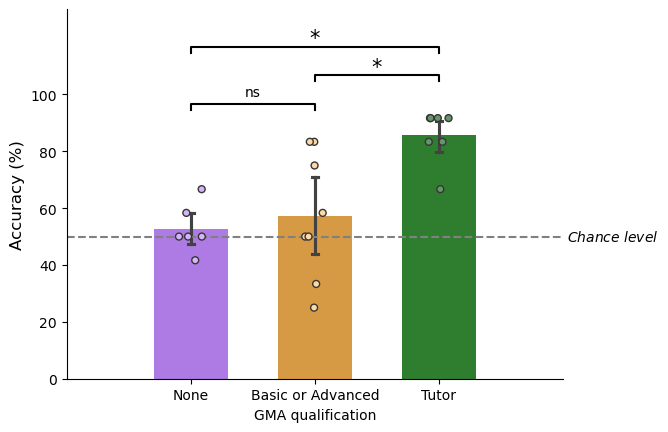

In [34]:
# ---- Accuracy by Experience Level
palette_points = {'None': "#d5b4f9", 'Basic or Advanced': "#FFD9A5", 'Tutor': "#639669"}
sns.barplot(df_norepeat, y = 'Accuracy_pc', x = 'GMA qualification', capsize=0.05, palette = palette, width = 0.6)
sns.stripplot(df_norepeat, y = 'Accuracy_pc', x = 'GMA qualification', edgecolor = "#363636", palette=palette_points, linewidth= 1)
plt.ylabel('Accuracy (%)', fontsize = 12)
ax = plt.gca()
ax.set_xticks([0,1, 2])
ax.set_xlim(-1, 3)
ax.set_yticks(np.arange(0,110, 20))
ax.axhline(y = 50, color = 'grey', linestyle = '--')

plt.text(3.4, 50, r"$\it{Chance\ level}$", ha='center', va='center')
plt.ylim(0,130)

# # Significance level annotations
max = df_norepeat['Accuracy_pc'].max()
gap = 3
inter_gap = 10
annotate_sig(ax, 0, 1, max + gap , 'ns')    # group1 vs group2
annotate_sig(ax, 1, 2, max + gap + inter_gap, '*')   # group2 vs group3
annotate_sig(ax, 0, 2, max + gap + inter_gap*2, '*')   # group1 vs group3
sns.despine()
# plt.savefig('Accuracy_vs_Experience.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# One-sample t-test comparing to chance level
group_data = []
pvals = []
statvals = []
for status in df_norepeat['GMA qualification'].unique():
    group = df_norepeat[df_norepeat['GMA qualification']==status]['Accuracy_pc'].values
    group_data.append(group)
    # stat, p = stats.ttest_1samp(group, 50)
    stat, p = stats.wilcoxon(group - 50, alternative='two-sided')
    pval_shap = round(stats.shapiro(group)[1], 3)
    print(f'{status}: p-value: {pval_shap}')
    
    pvals.append(p)
    statvals.append(stat)

pvals_corr = multipletests(pvals, method='bonferroni')[1]

# Place values in table
table = []
for i, status in enumerate(df_norepeat['GMA qualification'].unique()):
    table.append([status, round(statvals[i], 3),round(pvals[i], 3), round(pvals_corr[i], 3)]) 
print(tabulate(table, headers=['GMA qualification', 'Wilcoxon test statistic', 'p-value', 'p-value (corrected)'], tablefmt='github'))

None: p-value: 0.473
Basic or Advanced: p-value: 0.451
Tutor: p-value: 0.006
| GMA qualification   |   Wilcoxon test statistic |   p-value |   p-value (corrected) |
|---------------------|---------------------------|-----------|-----------------------|
| None                |                       1   |     0.5   |                 1     |
| Basic or Advanced   |                       5.5 |     0.375 |                 1     |
| Tutor               |                       0   |     0.016 |                 0.047 |


In [36]:
# Group differences
stat, p = stats.kruskal(group_data[0], group_data[1], group_data[2])
print(f"\nKruskal-Wallis H-statistic = {stat:.3f}")
print(f"p-value = {p:.4f}")


Kruskal-Wallis H-statistic = 11.051
p-value = 0.0040


In [37]:
posthoc_results = pg.pairwise_tests(dv='Accuracy_pc', between='GMA qualification', data=df_norepeat, padjust='bonferroni', parametric=False)
table = posthoc_results[['A', 'B', 'U-val', 'p-unc', 'p-corr']].rename(columns = {'p-unc': 'p-value', 'p-corr': 'p-value (corrected)'}).round(3)
print(tabulate(table, headers=table.columns, tablefmt='github'))

|    | A                 | B     |   U-val |   p-value |   p-value (corrected) |
|----|-------------------|-------|---------|-----------|-----------------------|
|  0 | Basic or Advanced | None  |    27.5 |     0.691 |                 1     |
|  1 | Basic or Advanced | Tutor |     5   |     0.008 |                 0.024 |
|  2 | None              | Tutor |     0.5 |     0.003 |                 0.01  |


In [38]:
table = df_norepeat.groupby('GMA qualification')['Accuracy_pc'].agg(['mean', 'median', 'min', 'max'])
table.to_csv('Experience_effect_stats.csv')
print(tabulate(table.round(1), headers = 'keys', tablefmt = 'github'))

| GMA qualification   |   mean |   median |   min |   max |
|---------------------|--------|----------|-------|-------|
| Basic or Advanced   |   57.3 |     54.2 |  25   |  83.3 |
| None                |   52.8 |     50   |  41.7 |  66.7 |
| Tutor               |   85.7 |     91.7 |  66.7 |  91.7 |


In [43]:
table = df[['ID', 'Accuracy_pc', 'GMA qualification', 'Round']].reset_index(drop=True).sort_values(by = 'ID')
table.to_csv('Participant_accuracy_scores.csv')
print(tabulate(table.round(1).reset_index(drop=True), headers = 'keys', tablefmt = 'github'))

|    |   ID |   Accuracy_pc | GMA qualification   |   Round |
|----|------|---------------|---------------------|---------|
|  0 |    1 |          50   | Basic or Advanced   |       1 |
|  1 |    2 |          50   | None                |       1 |
|  2 |    3 |          25   | Basic or Advanced   |       1 |
|  3 |    4 |          58.3 | Basic or Advanced   |       1 |
|  4 |    5 |          41.7 | None                |       1 |
|  5 |    6 |          66.7 | None                |       1 |
|  6 |    7 |          58.3 | None                |       1 |
|  7 |    8 |          50   | None                |       1 |
|  8 |    9 |          50   | None                |       1 |
|  9 |   10 |          33.3 | Basic or Advanced   |       1 |
| 10 |   11 |          83.3 | Basic or Advanced   |       1 |
| 11 |   12 |          50   | Basic or Advanced   |       1 |
| 12 |   13 |          75   | Basic or Advanced   |       1 |
| 13 |   14 |          83.3 | Basic or Advanced   |       1 |
| 14 |  

#### Motor Pattern

In [48]:
# percentage of people who got video correct
video_info = {}
for i in range(1, 13):
    video_info[i] = {'All participants_accuracy': df_norepeat[f'Cor_auto_{i}'].mean(),
                     'All participants_confidence': df_norepeat[f'{i}_Confidence'].mean()}
    for status in df_norepeat['GMA qualification'].unique():
        video_info[i][f'{status}_accuracy'] = df_norepeat[df_norepeat['GMA qualification'] == status][f'Cor_auto_{i}'].mean()
        video_info[i][f'{status}_confidence'] = df_norepeat[df_norepeat['GMA qualification'] == status][f'{i}_Confidence'].mean()

video_info_df = (
    pd.DataFrame.from_dict(video_info, orient='index', columns=video_info[1].keys())
    .reset_index()
    .rename(columns={'index': 'Video'})
    .merge(truth, on='Video', how='left')
)

# percentage
for col in video_info_df.columns:
    if 'accuracy' in col:
        video_info_df[col+'_pc'] = 100*video_info_df[col]

In [ ]:
for i in ['All participants','None', 'Basic or Advanced', 'Tutor']:
    nofm, fm = video_info_df[video_info_df['Video']!=2].groupby('label (0 = FM-, 1= FM+)')[f'{i}_accuracy_pc'].mean().values
    print(f'Accuracy: FM-: {round(nofm, 2)}, FM+: {round(fm, 2)}')

Accuracy: FM-: 71.43, FM+: 67.46
Accuracy: FM-: 56.67, FM+: 50.0
Accuracy: FM-: 62.5, FM+: 60.42
Accuracy: FM-: 94.29, FM+: 90.48


Mann-Whitney U test statistic: 20.0, p-value: 0.80853
0: One-sample t-test statistic: 1.334, p-value: 0.47947
1: One-sample t-test statistic: 3.143, p-value: 0.05117


/var/folders/yg/q5lqfgkx7rn0kftjl5kbsy4w0000gn/T/ipykernel_88905/2033528997.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(video_info_df, y = 'All participants_accuracy_pc', x = 'label (0 = FM-, 1= FM+)', capsize=0.05, palette= colors)


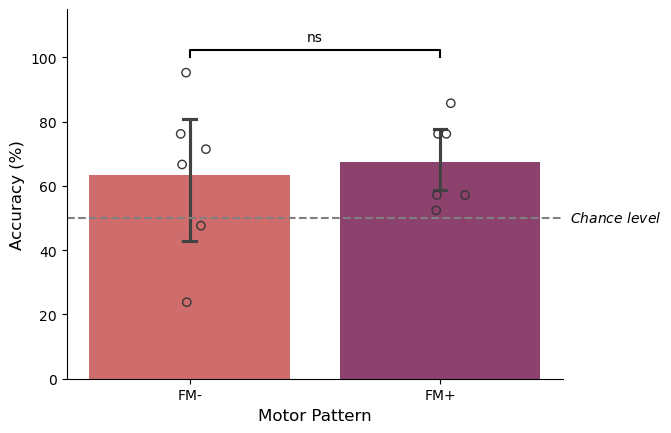

In [655]:
# sns.barplot(video_correct_df, y = f'Correctness_all_pc', x = 'label (0 = FM-, 1= FM+)', capsize=0.1)

kws = {"s": 6, "facecolor": "none", "linewidth": 1}
colors = sns.color_palette("flare", n_colors=2)

sns.barplot(video_info_df, y = 'All participants_accuracy_pc', x = 'label (0 = FM-, 1= FM+)', capsize=0.05, palette= colors)
sns.stripplot(video_info_df, y = 'All participants_accuracy_pc', x = 'label (0 = FM-, 1= FM+)', size = 6, edgecolor = "#363636", **kws)
plt.xlabel('Motor Pattern', fontsize = 12)
plt.ylabel('Accuracy (%)', fontsize = 12)
plt.text(1.7, 50, r"$\it{Chance\ level}$", ha='center', va='center')
plt.ylim(0,115)
ax = plt.gca()
ax.set_xticks([0,1])
ax.set_xticklabels(['FM-', 'FM+'])
ax.set_yticks(np.arange(0,110, 20))
ax.axhline(y = 50, color = 'grey', linestyle = '--')
sns.despine()
max = video_info_df['All participants_accuracy_pc'].max()
annotate_sig(ax, 0, 1, max + 5 , 'ns')    # group1 vs group2
plt.savefig('Accuracy_vs_MotorPattern.png', dpi=300, bbox_inches='tight')

# Mann-Whitney U test for tutor vs non-tutor
A = video_info_df[video_info_df['label (0 = FM-, 1= FM+)'] == 1][f'All participants_accuracy_pc']
B = video_info_df[video_info_df['label (0 = FM-, 1= FM+)'] == 0][f'All participants_accuracy_pc']
stat, p = mannwhitneyu(A, B, alternative='two-sided')
print(f'Mann-Whitney U test statistic: {stat}, p-value: {round(p, 5)}')

# One-sample t-test compared to chance level
group_data = []
pvals = []
statvals = []
for label in video_info_df['label (0 = FM-, 1= FM+)'].unique():
    group = video_info_df[video_info_df['label (0 = FM-, 1= FM+)']==label]['All participants_accuracy_pc'].values
    group_data.append(group)
    stat, p = stats.ttest_1samp(group, 50)
    pvals.append(p)
    statvals.append(stat)

pvals_corr = multipletests(pvals, method='bonferroni')[1]
for i, label in enumerate(video_info_df['label (0 = FM-, 1= FM+)'].unique()):
    print(f'{label}: One-sample t-test statistic: {round(statvals[i], 3)}, p-value: {round(pvals_corr[i], 5)}')


In [656]:
table = video_info_df.groupby('label (0 = FM-, 1= FM+)')['All participants_accuracy_pc'].agg(['mean', 'median', 'min', 'max'])
table.to_csv('Motor_Pattern_effect_stats.csv')
print(tabulate(table.round(1), headers = 'keys', tablefmt = 'github'))

|   label (0 = FM-, 1= FM+) |   mean |   median |   min |   max |
|---------------------------|--------|----------|-------|-------|
|                         0 |   63.5 |     69   |  23.8 |  95.2 |
|                         1 |   67.5 |     66.7 |  52.4 |  85.7 |


In [663]:
table = video_info_df[['Video', 'All participants_accuracy_pc', 'label (0 = FM-, 1= FM+)']]
table.to_csv('Video_accuracy_scores.csv')
print(tabulate(table.round(1), headers = 'keys', tablefmt = 'github'))

|    |   Video |   All participants_accuracy_pc |   label (0 = FM-, 1= FM+) |
|----|---------|--------------------------------|---------------------------|
|  0 |       1 |                           66.7 |                         0 |
|  1 |       2 |                           23.8 |                         0 |
|  2 |       3 |                           85.7 |                         1 |
|  3 |       4 |                           57.1 |                         1 |
|  4 |       5 |                           57.1 |                         1 |
|  5 |       6 |                           47.6 |                         0 |
|  6 |       7 |                           52.4 |                         1 |
|  7 |       8 |                           95.2 |                         0 |
|  8 |       9 |                           76.2 |                         0 |
|  9 |      10 |                           76.2 |                         1 |
| 10 |      11 |                           76.2 |               

New 

In [144]:
motor_pattern_accuracy = df_norepeat[['Accuracy_FM0', 'Accuracy_FM1']].melt(var_name='Motor Pattern', value_name='Accuracy_pc')
motor_pattern_accuracy['Motor Pattern'] = motor_pattern_accuracy['Motor Pattern'].replace({'Accuracy_FM0': 'FM-', 'Accuracy_FM1': 'FM+'})

In [150]:
print(round(stats.shapiro(motor_pattern_accuracy[motor_pattern_accuracy['Motor Pattern']=='FM-']['Accuracy_pc'])[1], 3))
print(round(stats.shapiro(motor_pattern_accuracy[motor_pattern_accuracy['Motor Pattern']=='FM+']['Accuracy_pc'])[1], 3))

0.006
0.062


In [165]:
print(tabulate(df_norepeat[['Accuracy_FM1', 'Accuracy_FM0']].round(1), headers='keys', tablefmt='github'))

|   ID |   Accuracy_FM1 |   Accuracy_FM0 |
|------|----------------|----------------|
|    2 |           33.3 |           66.7 |
|    5 |           50   |           33.3 |
|    6 |           66.7 |           66.7 |
|    7 |           50   |           66.7 |
|    8 |           50   |           50   |
|    9 |           50   |           50   |
|    1 |           50   |           50   |
|    3 |           16.7 |           33.3 |
|    4 |           66.7 |           50   |
|   10 |           50   |           16.7 |
|   11 |           83.3 |           83.3 |
|   12 |           50   |           50   |
|   13 |           83.3 |           66.7 |
|   14 |           83.3 |           83.3 |
|   15 |           83.3 |           83.3 |
|   16 |          100   |           83.3 |
|   17 |          100   |           83.3 |
|   18 |           83.3 |           83.3 |
|   19 |          100   |           83.3 |
|   20 |           66.7 |           66.7 |
|   21 |          100   |           83.3 |


/var/folders/yg/q5lqfgkx7rn0kftjl5kbsy4w0000gn/T/ipykernel_10315/2350058717.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(motor_pattern_accuracy, y = 'Accuracy_pc', x = 'Motor Pattern', capsize=0.05, palette= colors)


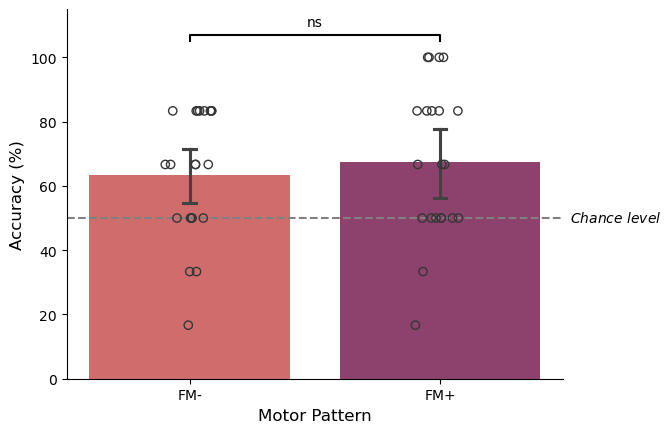

In [145]:
kws = {"s": 6, "facecolor": "none", "linewidth": 1}
colors = sns.color_palette("flare", n_colors=2)

sns.barplot(motor_pattern_accuracy, y = 'Accuracy_pc', x = 'Motor Pattern', capsize=0.05, palette= colors)
sns.stripplot(motor_pattern_accuracy, y = 'Accuracy_pc', x = 'Motor Pattern', size = 6, edgecolor = "#363636", **kws)
plt.xlabel('Motor Pattern', fontsize = 12)
plt.ylabel('Accuracy (%)', fontsize = 12)
plt.text(1.7, 50, r"$\it{Chance\ level}$", ha='center', va='center')
plt.ylim(0,115)
ax = plt.gca()
ax.set_xticks([0,1])
ax.set_xticklabels(['FM-', 'FM+'])
ax.set_yticks(np.arange(0,110, 20))
ax.axhline(y = 50, color = 'grey', linestyle = '--')
sns.despine()
max = motor_pattern_accuracy['Accuracy_pc'].max()
annotate_sig(ax, 0, 1, max + 5 , 'ns')    # group1 vs group2
plt.savefig('Accuracy_vs_MotorPattern.png', dpi=300, bbox_inches='tight')

In [166]:
stat, p = stats.wilcoxon(df_norepeat['Accuracy_FM1'], df_norepeat['Accuracy_FM0'])
print(f"\nWilcoxon test statistic = {stat:.3f}, p: {p:.3f}")


Wilcoxon test statistic = 20.500, p: 0.258


In [167]:
stat_vals = []
p_vals = []
for i in [0,1]:
    stat, p = stats.wilcoxon(df_norepeat[f'Accuracy_FM{i}'] - 50)
    stat_vals.append(stat)
    p_vals.append(p)

p_vals_corr = multipletests(p_vals, method='bonferroni')[1]
for i, label in enumerate(['FM-', 'FM+']):
    print(f'{label}: One-sample Wilcoxon test statistic: {round(stat_vals[i], 3)}, p-value: {round(p_vals_corr[i], 3)}')

FM-: One-sample Wilcoxon test statistic: 21.0, p-value: 0.027
FM+: One-sample Wilcoxon test statistic: 9.0, p-value: 0.012


In [169]:
table = motor_pattern_accuracy.groupby('Motor Pattern')['Accuracy_pc'].agg(['mean', 'median', 'min', 'max'])
table.to_csv('Motor_Pattern_effect_stats.csv')
print(tabulate(table.round(1), headers = 'keys', tablefmt = 'github'))

| Motor Pattern   |   mean |   median |   min |   max |
|-----------------|--------|----------|-------|-------|
| FM+             |   67.5 |     66.7 |  16.7 | 100   |
| FM-             |   63.5 |     66.7 |  16.7 |  83.3 |


#### Confidence

In [45]:
df_norepeat = df_norepeat.copy()
df_norepeat.loc[:, 'Mean_confidence'] = df_norepeat[[col for col in df_norepeat.columns if ('Conf' in col)]].mean(axis = 1)

Per video

In [ ]:
# Melt the correctness and confidence values separately
df_correctness = video_info_df.melt(
    id_vars=['Video', 'label (0 = FM-, 1= FM+)'],
    value_vars=[col for col in video_info_df.columns if ('accuracy' in col) & ('pc' not in col)],
    var_name='GMA qualification',
    value_name='Accuracy'
)

df_confidence = video_info_df.melt(
    id_vars=['Video', 'label (0 = FM-, 1= FM+)'],
    value_vars=[col for col in video_info_df.columns if ('confidence' in col)],
    var_name='GMA qualification',
    value_name='Confidence'
)

# Align 'type' values by removing the prefixes
df_correctness['GMA qualification'] = df_correctness['GMA qualification'].str.replace('_accuracy', '', regex=False)
df_confidence['GMA qualification'] = df_confidence['GMA qualification'].str.replace('_confidence', '', regex=False)

# Merge the melted DataFrames
df_combined = pd.merge(df_correctness, df_confidence, on=['Video', 'label (0 = FM-, 1= FM+)', 'GMA qualification'])

# Sort and display
df_combined = df_combined.sort_values(['Video', 'GMA qualification'])
df_combined['Accuracy_pc'] = 100*df_combined['Accuracy']

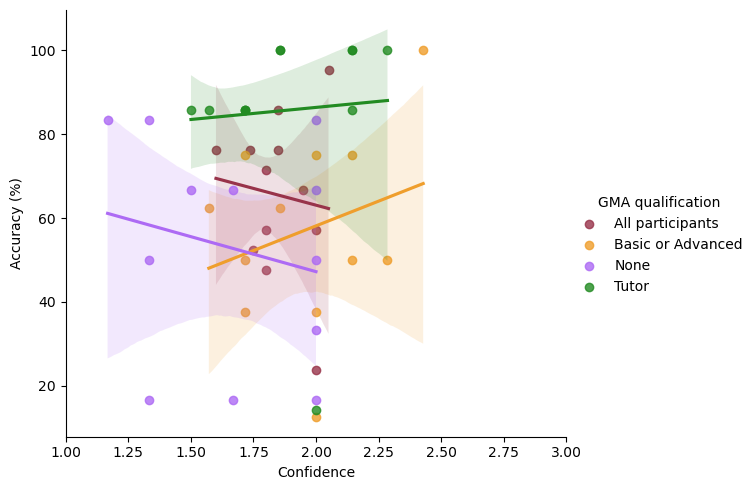

In [52]:
# Does confidence predict accuracy (per video)
colors = {'None': "#ad6af4", 'Basic or Advanced': "#EF9E2C", 'Tutor': 'forestgreen', 'All participants': "#970303"}
g = sns.lmplot(df_combined, x = 'Confidence', y = 'Accuracy_pc', hue = 'GMA qualification', legend = True, aspect = 1.2, ci=95, n_boot= 10000, palette = palette)   
plt.xlabel('Confidence')
plt.ylabel('Accuracy (%)')
plt.xlim(1,3)
plt.savefig('Accuracy_vs_Confidence_video.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
pvals = []
rvals = []
sp_pvals = []
sp_rvals = []
for i in subgroups:
    pval_shap1 = round(stats.shapiro(video_info_df[f'{i}_confidence'])[1], 3)
    pval_shap2 = round(stats.shapiro(video_info_df[f'{i}_accuracy'])[1], 3)
    print(f'{i}: p-value: {pval_shap1}, {pval_shap2}')

    r, p = stats.pearsonr(video_info_df[f'{i}_confidence'], video_info_df[f'{i}_accuracy'])
    sp_r, sp_p = stats.spearmanr(video_info_df[f'{i}_confidence'], video_info_df[f'{i}_accuracy'])
    
    sp_pvals.append(sp_p)
    sp_rvals.append(sp_r)
    pvals.append(p)
    rvals.append(r)
pvals_corr = multipletests(pvals, method='bonferroni')[1]
sp_pvals_corr = multipletests(sp_pvals, method='bonferroni')[1]

# Place values in table
table = []
for i, status in enumerate(subgroups):
    table.append([status, round(rvals[i], 3),round(pvals[i], 3), round(pvals_corr[i], 3)]) 
print(tabulate(table, headers=['GMA qualification', 'Pearson`s R correlation coefficient', 'p-value', 'p-value (corrected)'], tablefmt='github'))
print('\n')
# Place values in table
table = []
for i, status in enumerate(subgroups):
    table.append([status, round(sp_rvals[i], 3),round(sp_pvals[i], 3), round(sp_pvals_corr[i], 3)]) 
print(tabulate(table, headers=['GMA qualification', 'Spearman`s rho coefficient', 'p-value', 'p-value (corrected)'], tablefmt='github'))

All participants: p-value: 0.643, 0.782
None: p-value: 0.023, 0.061
Basic or Advanced: p-value: 0.729, 0.873
Tutor: p-value: 0.467, 0.0
| GMA qualification   |   Pearson`s R correlation coefficient |   p-value |   p-value (corrected) |
|---------------------|---------------------------------------|-----------|-----------------------|
| All participants    |                                -0.109 |     0.736 |                     1 |
| None                |                                -0.205 |     0.522 |                     1 |
| Basic or Advanced   |                                 0.267 |     0.402 |                     1 |
| Tutor               |                                 0.062 |     0.848 |                     1 |


| GMA qualification   |   Pearson`s R correlation coefficient |   p-value |   p-value (corrected) |
|---------------------|---------------------------------------|-----------|-----------------------|
| All participants    |                                 0.016 

In [59]:
print(f'Difference between: {subgroups[1]}, {subgroups[2]}, {subgroups[3]}')
stat, p = stats.kruskal(video_info_df[f'{subgroups[1]}_confidence'].values, video_info_df[f'{subgroups[2]}_confidence'].values, video_info_df[f'{subgroups[3]}_confidence'].values)
print(f"Kruskal-Wallis H-statistic = {stat:.3f}, p: {p:.4f}")

Difference between: None, Basic or Advanced, Tutor
Kruskal-Wallis H-statistic = 5.592, p: 0.0610


In [60]:
table = df_combined.groupby('GMA qualification')[['Accuracy', 'Confidence']].agg(['mean', 'median', 'min', 'max']).iloc[[2, 1, 3, 0]]
table['Accuracy'] = 100*table['Accuracy']
table.to_csv('Confidence_Experience_effect_stats_video.csv')
print(tabulate(table.round(1), headers = 'keys', tablefmt = 'github'))

| GMA qualification   |   ('Accuracy', 'mean') |   ('Accuracy', 'median') |   ('Accuracy', 'min') |   ('Accuracy', 'max') |   ('Confidence', 'mean') |   ('Confidence', 'median') |   ('Confidence', 'min') |   ('Confidence', 'max') |
|---------------------|------------------------|--------------------------|-----------------------|-----------------------|--------------------------|----------------------------|-------------------------|-------------------------|
| None                |                   52.8 |                     58.3 |                  16.7 |                  83.3 |                      1.7 |                        1.7 |                     1.2 |                     2   |
| Basic or Advanced   |                   57.3 |                     56.2 |                  12.5 |                 100   |                      2   |                        2   |                     1.6 |                     2.4 |
| Tutor               |                   85.7 |                     85.

In [61]:
table = video_info_df[[col for col in video_info_df.columns if ('pc' in col) | ('conf' in col) | ('Video' in col)]]
table.to_csv('Accuracy_Confidence_scores_video.csv')
print(tabulate(table.round(1), headers = 'keys', tablefmt = 'github'))

|    |   Video |   All participants_confidence |   None_confidence |   Basic or Advanced_confidence |   Tutor_confidence |   All participants_accuracy_pc |   None_accuracy_pc |   Basic or Advanced_accuracy_pc |   Tutor_accuracy_pc |
|----|---------|-------------------------------|-------------------|--------------------------------|--------------------|--------------------------------|--------------------|---------------------------------|---------------------|
|  0 |       1 |                           2   |               1.7 |                            2   |                2.1 |                           66.7 |               66.7 |                            37.5 |               100   |
|  1 |       2 |                           2   |               2   |                            2   |                2   |                           23.8 |               50   |                            12.5 |                14.3 |
|  2 |       3 |                           1.8 |               2   |

Per participant

In [64]:
df_all = df_norepeat.copy()
df_all['GMA qualification'] = subgroups[0] # all participants
df_all = pd.concat([df_all, df_norepeat])

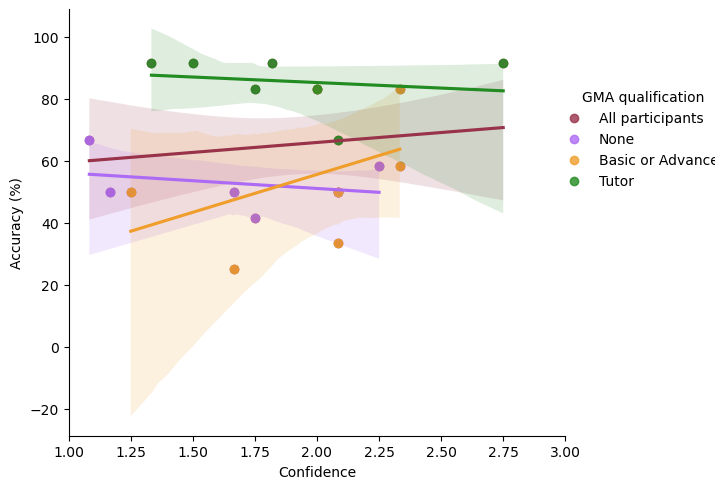

In [65]:
# Does confidence predict accuracy - participant 
g = sns.lmplot(df_all, x = 'Mean_confidence', y = 'Accuracy_pc', hue = 'GMA qualification', legend = True, aspect = 1.2, ci=95, n_boot= 100000, palette = palette)  

# Move legend
g._legend.set_bbox_to_anchor((0.95, 0.7))
# g._legend.set_loc('upper right')

plt.xlabel('Confidence')
plt.ylabel('Accuracy (%)')
plt.xlim(1,3)
plt.savefig('Accuracy_vs_Confidence_participant.png', dpi=300, bbox_inches='tight')

plt.show()

In [120]:
pvals = []
rvals = []
sp_pvals = []
sp_rvals = []
for i in df_all['GMA qualification'].unique():
    df_temp = df_all[df_all['GMA qualification']==i][['Mean_confidence', 'Accuracy_pc']].dropna()
    pval_shap1 = round(stats.shapiro(df_temp['Mean_confidence'])[1], 3)
    pval_shap2 = round(stats.shapiro(df_temp['Accuracy_pc'])[1], 3)
    
    print(f'{i}: p-value: {pval_shap1}, {pval_shap2}')
    r, p = stats.pearsonr(df_temp['Mean_confidence'], df_temp['Accuracy_pc'])

    sp_r, sp_p = stats.spearmanr(df_temp['Mean_confidence'], df_temp['Accuracy_pc'])
    sp_pvals.append(sp_p)
    sp_rvals.append(sp_r)
    pvals.append(p)
    rvals.append(r)

pvals_corr = multipletests(pvals, method='bonferroni')[1]
sp_pvals_corr = multipletests(sp_pvals, method='bonferroni')[1]

# Place values in table
table = []
for i, status in enumerate(df_all['GMA qualification'].unique()):
    table.append([status, round(rvals[i], 3),round(pvals[i], 3), round(pvals_corr[i], 3)]) 
print(tabulate(table, headers=['GMA qualification', 'Pearson`s R correlation coefficient', 'p-value', 'p-value (corrected)'], tablefmt='github'))

print('\n')
# Place values in table
table = []      
for i, status in enumerate(df_all['GMA qualification'].unique()):
    table.append([status, round(sp_rvals[i], 3),round(sp_pvals[i], 3), round(sp_pvals_corr[i], 3)]) 
print(tabulate(table, headers=['GMA qualification', 'Spearman`s rho coefficient', 'p-value', 'p-value (corrected)'], tablefmt='github'))

All participants: p-value: 0.727, 0.056
None: p-value: 0.556, 0.473
Basic or Advanced: p-value: 0.213, 0.424
Tutor: p-value: 0.634, 0.006
| GMA qualification   |   Pearson`s R correlation coefficient |   p-value |   p-value (corrected) |
|---------------------|---------------------------------------|-----------|-----------------------|
| All participants    |                                 0.132 |     0.58  |                     1 |
| None                |                                -0.274 |     0.599 |                     1 |
| Basic or Advanced   |                                 0.421 |     0.347 |                     1 |
| Tutor               |                                -0.178 |     0.703 |                     1 |


| GMA qualification   |   Spearman`s rho coefficient |   p-value |   p-value (corrected) |
|---------------------|------------------------------|-----------|-----------------------|
| All participants    |                        0.094 |     0.694 |            

In [63]:
# Group differences for confidence
group_data = []
df_clean = df_norepeat.dropna(subset = 'Mean_confidence')
for status in df_clean['GMA qualification'].unique():
    group = df_clean[df_clean['GMA qualification']==status]['Mean_confidence'].values
    group_data.append(group)

stat, p = stats.kruskal(group_data[0], group_data[1], group_data[2])
print(f"\nKruskal-Wallis H-statistic = {stat:.3f}, p: {p:.4f}")


Kruskal-Wallis H-statistic = 1.629, p: 0.4429


In [67]:
df_all_2 = df_all.copy()
df_all_2.drop(columns = {'Accuracy'}, inplace= True)
df_all_2.rename(columns = {'Accuracy_pc': 'Accuracy', 'Mean_confidence': 'Confidence'}, inplace = True)
table = df_all_2.groupby('GMA qualification')[['Accuracy', 'Confidence']].agg(['mean', 'median', 'min', 'max']).iloc[[2, 1, 3, 0]]
table.to_csv('Confidence_Experience_effect_stats_participant.csv')
print(tabulate(table.round(1), headers = 'keys', tablefmt = 'github'))

| GMA qualification   |   ('Accuracy', 'mean') |   ('Accuracy', 'median') |   ('Accuracy', 'min') |   ('Accuracy', 'max') |   ('Confidence', 'mean') |   ('Confidence', 'median') |   ('Confidence', 'min') |   ('Confidence', 'max') |
|---------------------|------------------------|--------------------------|-----------------------|-----------------------|--------------------------|----------------------------|-------------------------|-------------------------|
| None                |                   52.8 |                     50   |                  41.7 |                  66.7 |                      1.7 |                        1.7 |                     1.1 |                     2.2 |
| Basic or Advanced   |                   57.3 |                     54.2 |                  25   |                  83.3 |                      2   |                        2.1 |                     1.2 |                     2.3 |
| Tutor               |                   85.7 |                     91.

In [68]:
table = df_all_2[df_all_2['GMA qualification']!='All participants'][['GMA qualification', 'Accuracy', 'Confidence']].sort_index()
table.to_csv('Participant_accuracy_confidence_scores.csv')
print(tabulate(table.round(1), headers = 'keys', tablefmt = 'github'))

|   ID | GMA qualification   |   Accuracy |   Confidence |
|------|---------------------|------------|--------------|
|    1 | Basic or Advanced   |       50   |          2.1 |
|    2 | None                |       50   |          1.2 |
|    3 | Basic or Advanced   |       25   |          1.7 |
|    4 | Basic or Advanced   |       58.3 |          2.3 |
|    5 | None                |       41.7 |          1.8 |
|    6 | None                |       66.7 |          1.1 |
|    7 | None                |       58.3 |          2.2 |
|    8 | None                |       50   |          1.7 |
|    9 | None                |       50   |          2.1 |
|   10 | Basic or Advanced   |       33.3 |          2.1 |
|   11 | Basic or Advanced   |       83.3 |          2.3 |
|   12 | Basic or Advanced   |       50   |          1.2 |
|   13 | Basic or Advanced   |       75   |        nan   |
|   14 | Basic or Advanced   |       83.3 |          2   |
|   15 | Tutor               |       83.3 |          1.8

#### Tutor test-retest

In [69]:
# Test-retest agreement --- with cohens kappa agreement 
df_allrepeat = df[df.duplicated('ID', keep=False)]
df_allrepeat = df_allrepeat[[col for col in df_allrepeat.columns if ('Fidgety' in col )| ('ID' in col)]]

# Step 1: Count repeated IDs to assign round numbers
df_allrepeat['round'] = df_allrepeat.groupby('ID').cumcount() + 1

# Step 2: Reshape the DataFrame using `melt`
df_melted = df_allrepeat.melt(id_vars=['ID', 'round'], var_name='metric', value_name='value')

# Step 3: Create new column names like Cor_auto_1_round1, etc.
df_melted['metric_round'] = df_melted['metric'] + '_round' + df_melted['round'].astype(str)

# Step 4: Pivot so that each ID gets its own row, with new metric_round columns
df_wide = df_melted.pivot(index='ID', columns='metric_round', values='value')

# Optional: reset index if you want ID back as a column
df_wide = df_wide.reset_index()
# Keep ID as first column
id_col = df_wide['ID']
df_wide = df_wide.drop(columns='ID')

# Sort columns by metric number and round number
sorted_columns = sorted(df_wide.columns, key=lambda x: (
    int(x.split('_')[0]),  # metric number (e.g., Cor_auto_1 → 1)
    int(x.split('round')[-1])  # round number
))

# Reassign sorted columns and re-add ID
df_wide = pd.concat([id_col, df_wide[sorted_columns]], axis=1)

In [70]:
ratings_round1 = df_wide[[col for col in df_wide.columns if 'round1' in col]].values
ratings_round2 = df_wide[[col for col in df_wide.columns if 'round2' in col]].values
for i in range(len(ratings_round1)):
    
    kappa = cohen_kappa_score(ratings_round1[i], ratings_round2[i])

    print(f'Rater {i+1}: Cohen\'s kappa = {kappa:.3f}')
    # print(f'Round 1: {ratings_round1[i]}')
    # print(f'Round 2: {ratings_round2[i]}')

Rater 1: Cohen's kappa = 0.657
Rater 2: Cohen's kappa = 0.667
Rater 3: Cohen's kappa = 0.833
Rater 4: Cohen's kappa = 0.333
Rater 5: Cohen's kappa = 0.824


In [72]:
# tutor confidence
df_allrepeat_conf = df[df.duplicated('ID', keep=False)]
df_allrepeat_conf = df_allrepeat_conf[[col for col in df_allrepeat_conf.columns if ('Conf' in col )| ('ID' in col)]] 
round1_conf = df_allrepeat_conf.iloc[:5].drop(columns = 'ID').mean(axis = 1).values
round2_conf = df_allrepeat_conf.iloc[5:].drop(columns = 'ID').mean(axis = 1).values

In [73]:
stat, p = stats.wilcoxon(round1_conf, round2_conf)
print(f'Wilcoxon signed-rank test statistic: {stat}, p: {p}')

Wilcoxon signed-rank test statistic: 4.0, p: 0.875


#### Agreement amoung groups

In [ ]:
# interrater reliability
kappa_list = {}
for i in df_norepeat['GMA qualification'].unique():
    df_temp = df_norepeat[df_norepeat['GMA qualification']==i]
    df_temp = df_temp[[col for col in df_temp if 'Fidgety' in col]].T

    category_counts = df_temp.apply(lambda row: pd.Series([sum(row == 0), sum(row == 1)]), axis=1)
    category_counts.columns = ['No', 'Yes']

    kappa = fleiss_kappa(category_counts.values)
    kappa_list[i] = kappa

df_temp = df_norepeat[[col for col in df_norepeat if 'Fidgety' in col]].T
category_counts = df_temp.apply(lambda row: pd.Series([sum(row == 0), sum(row == 1)]), axis=1)
category_counts.columns = ['No', 'Yes']

kappa = fleiss_kappa(category_counts.values)
kappa_list['All participants'] = kappa
print(tabulate(pd.DataFrame.from_dict(kappa_list, orient='index', columns=['Fleiss_Kappa']).round(3), headers=['GMA qualification', 'Fleiss_Kappa'], tablefmt='github'))

| GMA qualification   |   Fleiss_Kappa |
|---------------------|----------------|
| None                |          0.108 |
| Basic or Advanced   |          0.098 |
| Tutor               |          0.664 |
| All participants    |          0.191 |


In [85]:
df_temp = df_norepeat[df_norepeat['GMA qualification']!='Tutor']
df_temp = df_temp[[col for col in df_temp if 'Fidgety' in col]].T

category_counts = df_temp.apply(lambda row: pd.Series([sum(row == 0), sum(row == 1)]), axis=1)
category_counts.columns = ['No', 'Yes']

kappa = round(fleiss_kappa(category_counts.values), 3)
print(f'Non-tutors Fleiss\' Kappa: {kappa}')

Non-tutors Fleiss' Kappa: 0.104


### Warming up effect

In [87]:
cols = ['Video', f'{subgroups[0]}_accuracy_pc', f'{subgroups[1]}_accuracy_pc', f'{subgroups[2]}_accuracy_pc', f'{subgroups[3]}_accuracy_pc']
video_info_df_melted = video_info_df[cols].melt(
    id_vars='Video',
    value_vars=cols[1:],
    var_name='GMA qualification',
    value_name='accuracy_pc'
)
video_info_df_melted['GMA qualification'] = video_info_df_melted['GMA qualification'].str.replace(r'_accuracy_pc', '')
video_info_df_melted['Video'] = video_info_df_melted['Video'].astype('int')
video_info_df_melted['part'] = video_info_df_melted['Video'].apply(lambda x: 1 if x in np.arange(1,7) else 2)

# video_info_df_melted = video_info_df_melted[video_info_df_melted['Video']!=2]

Linear regression to test effect

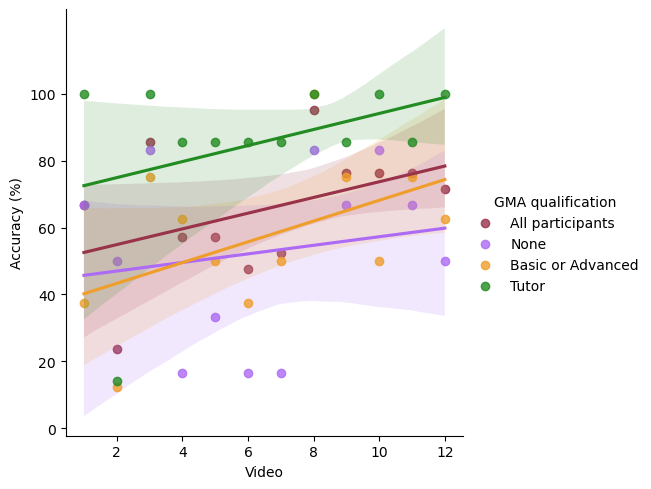

In [88]:
ax = sns.lmplot(video_info_df_melted, x = 'Video', y='accuracy_pc', hue = 'GMA qualification', ci=95, n_boot= 10000, palette = palette)
plt.ylabel('Accuracy (%)')
plt.yticks(np.arange(0,110, 20))
plt.show()

In [ ]:
from scipy.stats import linregress

results = []

# Loop through each Experience level
for level, group in video_info_df_melted.groupby('GMA qualification'):
    # Make sure x-values are numeric
    # (If 'Video' is categorical, assign numeric codes)
    if not pd.api.types.is_numeric_dtype(group['Video']):
        x = pd.factorize(group['Video'])[0]  # convert categories to integers
    else:
        x = group['Video']

    y = group['accuracy_pc']

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    results.append({
        'GMA qualification': level,
        'slope': slope,
        'intercept': intercept,
        'std_err': std_err
    })

# Create a summary DataFrame
results_df = pd.DataFrame(results).round(2)
print(results_df)

   GMA qualification  slope  intercept  std_err
0   All participants   2.35      50.22     1.51
1  Basic or Advanced   3.10      37.12     1.75
2               None   1.28      44.44     2.28
3              Tutor   2.40      70.13     1.93


In [121]:
pvals = []
rvals = []
sp_pvals = []       
sp_rvals = []

for i in video_info_df_melted['GMA qualification'].unique():
    df_temp = video_info_df_melted[video_info_df_melted['GMA qualification']==i][['Video', 'accuracy_pc']].dropna()
    # pval_shap1 = round(stats.shapiro(df_temp['Mean_confidence'])[1], 3)
    # pval_shap2 = round(stats.shapiro(df_temp['Accuracy_pc'])[1], 3)
    
    r, p = stats.pearsonr(df_temp['Video'], df_temp['accuracy_pc'])
    sp_r, sp_p = stats.spearmanr(df_temp['Video'], df_temp['accuracy_pc'])
    sp_pvals.append(sp_p)
    sp_rvals.append(sp_r)
    pvals.append(p)
    rvals.append(r)
    # print(f'{i}: r = {round(r, 2)}, p = {round(p,2)}')

pvals_corr = multipletests(pvals, method='bonferroni')[1]
sp_pvals_corr = multipletests(sp_pvals, method='bonferroni')[1]

# Place values in table
table = []
for i, status in enumerate(video_info_df_melted['GMA qualification'].unique()):
    table.append([status, round(rvals[i], 3),round(pvals[i], 3), round(pvals_corr[i], 3)]) 
print(tabulate(table, headers=['GMA qualification', 'Pearson`s R correlation coefficient', 'p-value', 'p-value (corrected)'], tablefmt='github'))

print('\n') 
# Place values in table
table = []       
for i, status in enumerate(video_info_df_melted['GMA qualification'].unique()):
    table.append([status, round(sp_rvals[i], 3),round(sp_pvals[i], 3), round(sp_pvals_corr[i], 3)]) 
print(tabulate(table, headers=['GMA qualification', 'Spearman`s rho coefficient', 'p-value', 'p-value (corrected)'], tablefmt='github'))

| GMA qualification   |   Pearson`s R correlation coefficient |   p-value |   p-value (corrected) |
|---------------------|---------------------------------------|-----------|-----------------------|
| All participants    |                                 0.442 |     0.151 |                 0.603 |
| None                |                                 0.175 |     0.587 |                 1     |
| Basic or Advanced   |                                 0.489 |     0.107 |                 0.428 |
| Tutor               |                                 0.366 |     0.241 |                 0.966 |


| GMA qualification   |   Spearman`s rho coefficient |   p-value |   p-value (corrected) |
|---------------------|------------------------------|-----------|-----------------------|
| All participants    |                        0.406 |     0.191 |                 0.763 |
| None                |                        0.165 |     0.609 |                 1     |
| Basic or Advanced   |           

T-test to test effect (first half vs. second)

In [ ]:
# accuracy per participants for the first 6 videos and the last 6 videos
parts = [np.arange(1,7), np.arange(7,13)]
dfs_list = []
for i, videos in enumerate(parts):
    df_norepeat_part = df_norepeat[['ID','GMA qualification']+[f'Cor_auto_{i}' for i in videos]].reset_index(drop=True)
    df_norepeat_part = df_norepeat_part.copy()
    df_norepeat_part.loc[:, f'Accuracy'] = 100*df_norepeat_part[[f'Cor_auto_{i}' for i in videos]].mean(axis=1)
    df_norepeat_part.loc[:, f'part'] = i+1
    dfs_list.append(df_norepeat_part[['ID', 'GMA qualification', f'Accuracy', 'part']])

df_parts = pd.concat([dfs_list[0], dfs_list[1]])

# add all scores again with new experience code for all

In [92]:
print(tabulate(pd.concat([dfs_list[0], dfs_list[1]], axis = 1), headers = 'keys', tablefmt = 'github'))

|    |   ID | GMA qualification   |   Accuracy |   part |   ID | GMA qualification   |   Accuracy |   part |
|----|------|---------------------|------------|--------|------|---------------------|------------|--------|
|  0 |    2 | None                |    33.3333 |      1 |    2 | None                |    66.6667 |      2 |
|  1 |    5 | None                |    33.3333 |      1 |    5 | None                |    50      |      2 |
|  2 |    6 | None                |    66.6667 |      1 |    6 | None                |    66.6667 |      2 |
|  3 |    7 | None                |    50      |      1 |    7 | None                |    66.6667 |      2 |
|  4 |    8 | None                |    50      |      1 |    8 | None                |    50      |      2 |
|  5 |    9 | None                |    33.3333 |      1 |    9 | None                |    66.6667 |      2 |
|  6 |    1 | Basic or Advanced   |    33.3333 |      1 |    1 | Basic or Advanced   |    66.6667 |      2 |
|  7 |    3 | Basic

In [93]:
df_parts_all = df_parts.copy()
df_parts_all['GMA qualification'] = subgroups[0] # all participants
df_parts_all = pd.concat([df_parts_all, df_parts])

In [96]:
# Container for results
results = []
results_pg = []

# Loop through each GExp group
for exp in list(df_parts_all['GMA qualification'].unique()):
    df_temp = df_parts_all[df_parts_all['GMA qualification'] == exp]
    # Pivot so each ID has two columns: part1 and part2
    wide = df_temp.pivot(index="ID", columns="part", values="Accuracy").dropna()
    
    # Run Wilcoxon signed-rank test
    stat, p = stats.wilcoxon(wide[1], wide[2])

    # test alt
    # print(exp)
    # print(pg.wilcoxon(wide[1], wide[2], alternative='two-sided'))
    
    # Store results
    results.append({
        "'GMA qualification'": exp,
        "n_pairs": len(wide),
        "Wilcoxon_statistic": stat,
        "p_value": p,
        "mean_part1": wide[1].mean(),
        "mean_part2": wide[2].mean()
    })

# Convert to DataFrame for clean display
results_df = pd.DataFrame(results)
results_df['p_value_corrected'] = multipletests(results_df['p_value'], method='bonferroni')[1]
print(tabulate(results_df.round(3), headers = 'keys', tablefmt = 'github'))

|    | 'GMA qualification'   |   n_pairs |   Wilcoxon_statistic |   p_value |   mean_part1 |   mean_part2 |   p_value_corrected |
|----|-----------------------|-----------|----------------------|-----------|--------------|--------------|---------------------|
|  0 | All participants      |        21 |                   26 |     0.009 |       56.349 |       74.603 |               0.037 |
|  1 | None                  |         6 |                    0 |     0.125 |       44.444 |       61.111 |               0.5   |
|  2 | Basic or Advanced     |         8 |                    3 |     0.078 |       45.833 |       68.75  |               0.312 |
|  3 | Tutor                 |         7 |                    6 |     0.219 |       78.571 |       92.857 |               0.875 |


In [97]:
# for i in video_info_df_melted['Experience level'].unique():
#     df_temp = video_info_df_melted[video_info_df_melted['Experience level']==i]
#     A = df_temp[df_temp['part']==1]['accuracy_pc'].values#.mean()
#     B = df_temp[df_temp['part']==2]['accuracy_pc'].values#.mean()
#     stat, p = mannwhitneyu(A, B, alternative='two-sided')
#     print(f'group {i}: Part 1 accuracy: {round(np.mean(A), 2)}, Part 2 accuracy: {round(np.mean(B), 2)} --> Mann-Whitney U test statistic: {stat}, p-value: {round(p, 5)}')

In [ ]:
# from matplotlib.colors import to_rgb, to_rgba
# import matplotlib.colors as mcolors

# def lighten_color(color, amount=0.5):
#     """
#     Lightens the given color by mixing it with white.
#     amount=0 returns the original color,
#     amount=1 returns white.
#     """
#     try:
#         c = mcolors.to_rgb(color)
#     except ValueError:
#         c = color[:3]  # if RGBA tuple

#     return tuple(1 - (1 - channel) * (1 - amount) for channel in c) + (1.0,)


In [99]:
# Bar plot - old version using sns
# ax = sns.barplot(df_parts_all, y = 'Accuracy', x = 'GExp', hue = 'part', capsize=0.05, palette = 'coolwarm', gap = 0.2, errorbar = None)

# # Overlay hollow markers manually
# bar_colors = list(set([patch.get_facecolor() for patch in ax.patches]))[::-1]
# light_bar_colors = []
# for i, color in enumerate(bar_colors):
#     light_bar_colors.append(lighten_color(color, amount=0.3))

# # Significance level annotations
# annotate_sig(ax, -0.2, 0.2, df_parts_all[df_parts_all['GExp']==0]['Accuracy'].max() + 5 , '*')

# # Add scatter points and connecting lines manually for each participant
# for id, exp in df_parts_all[['ID', 'GExp']].drop_duplicates().values:
#     df_temp = df_parts_all[(df_parts_all['ID'] == id) & (df_parts_all['GExp'] == exp)]
#     x = [exp-0.2+np.random.uniform(-0.06, 0.06, 1)[0], exp+0.2+np.random.uniform(-0.06, 0.06, 1)[0]]
#     ax.plot(x,df_temp['Accuracy'], color = 'k', linewidth = 1)
#     for i in [0,1]:
#         ax.scatter(x[i], df_temp['Accuracy'].iloc[i], color = light_bar_colors[i], edgecolors='k', zorder = 10)

# # Aesthetics
# ax.axhline(y = 50, color = 'grey', linestyle = '--')
# plt.text(4, 50, r"$\it{Chance\ level}$", ha='center', va='center')
# plt.xlabel('GMA qualification', fontsize = 12)
# plt.ylabel('Accuracy (%)', fontsize = 12)
# ax.set_xticks([0,1, 2, 3])
# plt.ylim(0,120)
# plt.yticks(np.arange(0,110, 20))
# ax.set_xticklabels(['All levels', 'None', 'Basic or Advanced', 'Tutor'])
# plt.legend( frameon = False, loc='lower center', bbox_to_anchor=(0.5, 1.02), ncols = 2, labels = ['First 6 videos', 'Last 6 videos'])
# sns.despine(ax=ax, top=True, right=True)
# plt.show()

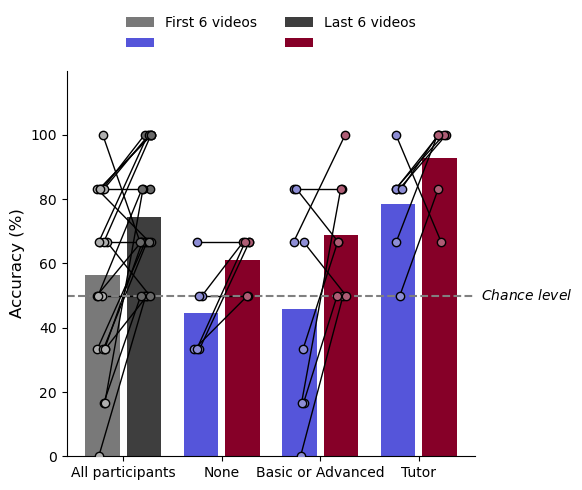

In [100]:
# --- Palette ---
bar_colors = ["#797979"] + ["#5555da"]*3 + ["#3E3E3E"] +[ "#860028"]*3 
marker_colors = {subgroups[0]: {0: "#AFAFAF", 1:"#686868"},
                 subgroups[1]: {0:"#8d8dd5", 1:"#AE5D75"},
                 subgroups[2]: {0:"#8d8dd5", 1:"#AE5D75"},
                 subgroups[3]: {0:"#8d8dd5", 1:"#AE5D75"}}

x_pos = {subgroups[0]: 0,
                 subgroups[1]: 1,
                 subgroups[2]: 2,
                 subgroups[3]: 3}

# --- Compute bar means manually ---
bar_data = (
    df_parts_all.groupby(["GMA qualification", "part"])["Accuracy"]
    .mean()
    .reset_index()
)

# --- Parameters ---
width = 0.35

fig, ax = plt.subplots(figsize=(6, 5))

# --- Draw each bar one by one ---
j = 0
shift = [-0.6, 0.6]
for part in sorted(df_parts_all["part"].unique()):
    for x_positions, exp in enumerate(df_parts_all["GMA qualification"].unique()):
        # Compute mean accuracy for this group
        y = bar_data[(bar_data["GMA qualification"] == exp) & (bar_data["part"] == part)]["Accuracy"].values[0]
        
        # Compute x position
        i = sorted(df_parts_all["part"].unique()).index(part)
        x = x_positions + shift[i] * width

        # Draw bar
        ax.bar(x, y, width=width, color=bar_colors[j], edgecolor='k', linewidth=0, label = f'part {part}')
        j += 1

# --- Significance annotation ---
annotate_sig(ax, -0.2, 0.2, df_parts_all[df_parts_all['GMA qualification'] == 0]['Accuracy'].max() + 5, '*')

# --- Overlay participant points + connecting lines ---
for id, exp in df_parts_all[['ID', 'GMA qualification']].drop_duplicates().values:
    df_temp = df_parts_all[(df_parts_all['ID'] == id) & (df_parts_all['GMA qualification'] == exp)]
    x = [x_pos[exp] - width/2 - 0.05 + np.random.uniform(-0.06, 0.06),
         x_pos[exp] + width/2 + 0.05 + np.random.uniform(-0.06, 0.06)]
    
    ax.plot(x, df_temp['Accuracy'], color='k', linewidth=1)
    for i in [0, 1]:
        ax.scatter(
            x[i],
            df_temp['Accuracy'].iloc[i],
            color=marker_colors[exp][i],
            edgecolors='k',
            zorder=10
        )

# --- Aesthetics ---
ax.axhline(y=50, color='grey', linestyle='--')
plt.text(4.1, 50, r"$\it{Chance\ level}$", ha='center', va='center')

# plt.xlabel('GMA qualification', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
ax.set_xticks(list(x_pos.values()))
ax.set_xticklabels(list(x_pos.keys()))
plt.ylim(0, 120)
plt.yticks(np.arange(0, 110, 20))

# --- Legend & style ---
h, l = ax.get_legend_handles_labels()

plt.legend(
    [h[0] + h[1] + h[4] + h[5]][0], 
    ['First 6 videos', '', 'Last 6 videos', ''],
    frameon=False,
    loc='lower center',
    bbox_to_anchor=(0.5, 1.02),
    ncols=2,
    # labels=['First 6 videos', 'Last 6 videos']
)

sns.despine(ax=ax, top=True, right=True)
plt.tight_layout()
plt.show()

In [103]:
# Test mean differences in each part at each experience level are different from chance level
statvals = []
for exp in df_parts_all['GMA qualification'].unique():
    for part in df_parts_all['part'].unique():
        accuracy = df_parts_all[(df_parts_all['GMA qualification']==exp) & (df_parts_all['part'] == part)]['Accuracy'].values
        stat, p = stats.wilcoxon(accuracy - 50, alternative='two-sided')
        # print(exp, part, stat, p)
        statvals.append([exp, part, stat, p])

statvals = pd.DataFrame(statvals, columns = ['GMA qualification', 'part', 'Wilcoxon test statistic', 'p-value'])
statvals['p-value (corrected)'] = multipletests(statvals['p-value'], method='bonferroni')[1]
print(tabulate(statvals.round(3), headers = 'keys', tablefmt = 'github'))

|    | GMA qualification   |   part |   Wilcoxon test statistic |   p-value |   p-value (corrected) |
|----|---------------------|--------|---------------------------|-----------|-----------------------|
|  0 | All participants    |      1 |                      62.5 |     0.313 |                 1     |
|  1 | All participants    |      2 |                       0   |     0     |                 0.003 |
|  2 | None                |      1 |                       1   |     0.25  |                 1     |
|  3 | None                |      2 |                       0   |     0.125 |                 1     |
|  4 | Basic or Advanced   |      1 |                      16   |     0.836 |                 1     |
|  5 | Basic or Advanced   |      2 |                       0   |     0.062 |                 0.5   |
|  6 | Tutor               |      1 |                       0   |     0.031 |                 0.25  |
|  7 | Tutor               |      2 |                       0   |     0.016 |     

In [110]:
table = df_parts[df_parts['part']==1].merge(df_parts[df_parts['part']==2], on=['ID', 'GMA qualification'], suffixes=('_part1', '_part2')).drop(columns={'part_part1', 'part_part2'})
print(tabulate(table.round(3), headers = 'keys', tablefmt = 'github'))

|    |   ID | GMA qualification   |   Accuracy_part1 |   Accuracy_part2 |
|----|------|---------------------|------------------|------------------|
|  0 |    2 | None                |           33.333 |           66.667 |
|  1 |    5 | None                |           33.333 |           50     |
|  2 |    6 | None                |           66.667 |           66.667 |
|  3 |    7 | None                |           50     |           66.667 |
|  4 |    8 | None                |           50     |           50     |
|  5 |    9 | None                |           33.333 |           66.667 |
|  6 |    1 | Basic or Advanced   |           33.333 |           66.667 |
|  7 |    3 | Basic or Advanced   |            0     |           50     |
|  8 |    4 | Basic or Advanced   |           66.667 |           50     |
|  9 |   10 | Basic or Advanced   |           16.667 |           50     |
| 10 |   11 | Basic or Advanced   |           83.333 |           83.333 |
| 11 |   12 | Basic or Advanced   |   